## 1. Setup and Imports

In [1]:
import os
import sys
import math
import torch
import torch.nn as nn
import gc
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import json
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Setup device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA B200


## 2. Load Data

In [2]:
# Add src to path and import data generator
sys.path.insert(0, '../src')
from ModelDataGenerator_1 import build_dataloader

# Configuration - OPTIMAL DDPM HYPERPARAMETERS
BATCH_SIZE = 4
NUM_WORKERS = 4
EPOCHS = 20
LR = 2e-4  # 0.00002 - Optimal learning rate for DDPM
BETA_START = 0.0001
BETA_END = 0.02
NUM_DIFFUSION_TIMESTEPS = 1000
CHECKPOINT_DIR = '../models'
results_dir = '../results'

# Build dataloaders
train_loader = build_dataloader(split='train', batch_size=BATCH_SIZE, augment=True, num_workers=NUM_WORKERS)
val_loader = build_dataloader(split='val', batch_size=BATCH_SIZE, augment=False, num_workers=NUM_WORKERS)
test_loader = build_dataloader(split='test', batch_size=BATCH_SIZE, augment=False, num_workers=NUM_WORKERS)

print(f"✅ Data loaded: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

# Check one batch
(pre_sample, post_sample), target_sample = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  pre: {pre_sample.shape}")
print(f"  post: {post_sample.shape}")
print(f"  target: {target_sample.shape}")

💾 Pre-caching volumes into RAM for faster data loading...
✅ Cached 641 volumes in RAM
💾 Pre-caching volumes into RAM for faster data loading...
✅ Cached 113 volumes in RAM
💾 Pre-caching volumes into RAM for faster data loading...
✅ Cached 160 volumes in RAM
✅ Data loaded: Train=18269, Val=3221, Test=4560

Batch shapes:
  pre: torch.Size([4, 1, 256, 256])
  post: torch.Size([4, 1, 256, 256])
  target: torch.Size([4, 1, 256, 256])


## 3. Noise Schedule (DDPM)

In [3]:
EPOCHS = 40

In [5]:
class DDPMScheduler:
    def __init__(self, num_timesteps=1000, num_inference_steps=10, scheduler_type='non-uniform', beta_schedule='cosine'):
        
        self.num_timesteps = num_timesteps
        self.num_inference_steps = num_inference_steps
        self.scheduler_type = scheduler_type
        
        # Pre-compute noise schedule with optimal beta range [0.0001, 0.02]
        if beta_schedule == 'cosine':
            # Cosine annealing schedule
            s = 0.008
            steps = torch.arange(0, num_timesteps + 1, dtype=torch.float32)
            alphas_cumprod = torch.cos(((steps / num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1.0 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            betas = torch.clamp(betas, 0.0001, 0.9999)
        else:
            # Linear schedule (optimal for DDPM) with range [0.0001, 0.02]
            betas = torch.linspace(0.0001, 0.02, num_timesteps)
        
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))
        
        # Select timesteps based on strategy
        if scheduler_type == 'uniform':
            # Uniform spacing: every skip-th timestep
            skip = num_timesteps // num_inference_steps
            self.timesteps = torch.arange(0, num_timesteps, skip).long()[:num_inference_steps]
        
        elif scheduler_type == 'non-uniform':
            # Non-uniform: concentrate in noisy region
            if num_inference_steps == 50:
                # For 50 steps: more granular coverage
                self.timesteps = torch.linspace(0, num_timesteps - 1, num_inference_steps).long()
            else:
                # Adaptive non-uniform for other step counts
                num_stage1 = int(num_inference_steps * 0.4)
                num_stage2 = int(num_inference_steps * 0.6)
                
                if num_stage1 > 0:
                    stage1 = torch.linspace(0, 699, num_stage1 + 1)[:-1].ceil().long()
                else:
                    stage1 = torch.tensor([]).long()
                
                stage2 = torch.linspace(699, 999, num_stage2 + 1)[:-1].ceil().long()
                self.timesteps = torch.cat([stage1, stage2])
        
        else:
            raise ValueError(f"Unknown scheduler_type: {scheduler_type}")
    
    def register_buffer(self, name, tensor):
        setattr(self, name, tensor)
    
    def add_noise(self, x0, t, noise):
        """Forward process: x_t = sqrt(alpha_t)*x0 + sqrt(1-alpha_t)*eps"""
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x0 + sqrt_one_minus_alpha * noise

# Create scheduler with optimal configuration
scheduler = DDPMScheduler(num_timesteps=NUM_DIFFUSION_TIMESTEPS, num_inference_steps=10, scheduler_type='non-uniform', beta_schedule='cosine')
print(f"✅ Scheduler created with optimal config")
print(f"   Beta range: [0.0001, 0.02]")
print(f"   Timesteps: {NUM_DIFFUSION_TIMESTEPS}")
print(f"   Inference steps: 10")

✅ Scheduler created with optimal config
   Beta range: [0.0001, 0.02]
   Timesteps: 1000
   Inference steps: 10


## 4. Model Architecture

In [6]:
def get_timestep_embedding(timesteps, embedding_dim):
    """Build sinusoidal embeddings (from DDPM paper)"""
    assert len(timesteps.shape) == 1
    
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

class TimeEmbedding(nn.Module):
    """Sinusoidal timestep embedding with learned projection"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.SiLU(),
            nn.Linear(dim * 2, dim)
        )
    
    def forward(self, t):
        if t.dim() == 0:
            t = t.unsqueeze(0)
        emb = get_timestep_embedding(t, self.dim)
        return self.fc(emb)

class ResBlock(nn.Module):
    """Residual block with time conditioning"""
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        ng_in = max(1, in_ch // 4)
        ng_out = max(1, out_ch // 4)
        
        self.norm1 = nn.GroupNorm(ng_in, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(ng_out, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        
        self.time_fc = nn.Linear(time_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    
    def forward(self, x, t_emb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        h = h + self.time_fc(t_emb)[:, :, None, None]
        h = F.silu(self.norm2(h))
        h = self.conv2(h)
        return h + self.skip(x)

class FastDDPM(nn.Module):
    """Fast DDPM UNet for conditional denoising"""
    def __init__(self, in_ch=3, out_ch=1, base_ch=64, time_dim=128):
        super().__init__()
        self.time_emb = TimeEmbedding(time_dim)
        self.init_conv = nn.Conv2d(in_ch, base_ch, 3, padding=1)
        
        # Encoder
        self.enc1 = ResBlock(base_ch, base_ch * 2, time_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResBlock(base_ch * 2, base_ch * 4, time_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResBlock(base_ch * 4, base_ch * 8, time_dim)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ResBlock(base_ch * 8, base_ch * 8, time_dim)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, 2, 2)
        self.dec3 = ResBlock(base_ch * 4 + base_ch * 8, base_ch * 4, time_dim)
    
        self.upconv2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, 2)
        self.dec2 = ResBlock(base_ch * 2 + base_ch * 4, base_ch * 2, time_dim)
        
        self.upconv1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, 2)
        self.dec1 = ResBlock(base_ch + base_ch * 2, base_ch, time_dim)
        
        ng_final = max(1, base_ch // 4)
        self.final = nn.Sequential(
            nn.GroupNorm(ng_final, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, out_ch, 3, padding=1)
        )
    
    def forward(self, x, t):
        t_emb = self.time_emb(t)
        h = self.init_conv(x)
        
        e1 = self.enc1(h, t_emb)
        h = self.pool1(e1)
        e2 = self.enc2(h, t_emb)
        h = self.pool2(e2)
        e3 = self.enc3(h, t_emb)
        h = self.pool3(e3)
        
        h = self.bottleneck(h, t_emb)
        
        h = self.upconv3(h)
        h = torch.cat([h, e3], dim=1)
        h = self.dec3(h, t_emb)
        
        h = self.upconv2(h)
        h = torch.cat([h, e2], dim=1)
        h = self.dec2(h, t_emb)
        
        h = self.upconv1(h)
        h = torch.cat([h, e1], dim=1)
        h = self.dec1(h, t_emb)
        
        return self.final(h)

model = FastDDPM(in_ch=3, out_ch=1, base_ch=128, time_dim=256).to(DEVICE)
num_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model created with 3 input channels: {num_params:,} parameters")
print(f"   Base channels: 128 (2x larger) | Time embedding: 256 (2x larger)")
print(f"   Model size increase → Better feature representation → Higher SSIM")

✅ Model created with 3 input channels: 55,562,497 parameters
   Base channels: 128 (2x larger) | Time embedding: 256 (2x larger)
   Model size increase → Better feature representation → Higher SSIM


## 5. Training Setup

In [7]:
# Setup training
LR = 2e-4 
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler_device = DDPMScheduler(num_timesteps=1000, num_inference_steps=10, scheduler_type='non-uniform', beta_schedule='linear')

# Move all scheduler tensors to device
scheduler_device.betas = scheduler_device.betas.to(DEVICE)
scheduler_device.alphas = scheduler_device.alphas.to(DEVICE)
scheduler_device.alphas_cumprod = scheduler_device.alphas_cumprod.to(DEVICE)
scheduler_device.sqrt_alphas_cumprod = scheduler_device.sqrt_alphas_cumprod.to(DEVICE)
scheduler_device.sqrt_one_minus_alphas_cumprod = scheduler_device.sqrt_one_minus_alphas_cumprod.to(DEVICE)
scheduler_device.timesteps = scheduler_device.timesteps.to(DEVICE)

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
print("✅ Scheduler tensors moved to device")
print(f"   Using {len(scheduler_device.timesteps)} inference steps for high-quality generation")

# ========== Checkpoint Utilities ==========
def get_latest_checkpoint(checkpoint_dir, prefix='fastddpm_checkpoint_lin_sch'):
    """Get the latest checkpoint file by epoch number"""
    from pathlib import Path
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_files = list(checkpoint_dir.glob(f'{prefix}_*.pt'))
    
    if not checkpoint_files:
        return None
    
    checkpoints_with_epochs = []
    for ckpt in checkpoint_files:
        try:
            epoch = int(ckpt.stem.split('_')[-1])
            checkpoints_with_epochs.append((epoch, ckpt))
        except ValueError:
            continue
    
    if not checkpoints_with_epochs:
        return None
    
    latest_epoch, latest_ckpt = max(checkpoints_with_epochs, key=lambda x: x[0])
    return latest_ckpt, latest_epoch


def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Load checkpoint and return starting epoch and training state"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    start_epoch = checkpoint.get('epoch', 0) + 1
    history = checkpoint.get('history', {'epoch': [], 'train_loss': [], 'val_loss': []})
    best_loss = checkpoint.get('best_loss', float('inf'))
    
    return start_epoch, history, best_loss


def save_checkpoint(model, optimizer, epoch, history, best_loss, checkpoint_path):
    """Save checkpoint"""
    from datetime import datetime
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'best_loss': best_loss,
        'timestamp': datetime.now().isoformat()
    }
    torch.save(checkpoint, checkpoint_path)

print("✅ Checkpoint utilities defined")

# Check for existing checkpoint
print("\n🔍 Checking for existing checkpoints...")
latest_ckpt_info = get_latest_checkpoint(CHECKPOINT_DIR, prefix='fastddpm_checkpoint_lin_sch')

if latest_ckpt_info is not None:
    latest_ckpt_path, latest_epoch = latest_ckpt_info
    print(f"📂 Found checkpoint: {latest_ckpt_path.name}")
    
    start_epoch, history, best_loss = load_checkpoint(
        model, optimizer, latest_ckpt_path, DEVICE
    )
    
    print(f"✅ Loaded checkpoint from epoch {latest_epoch}")
    print(f"   Resuming training from epoch {start_epoch}")
    print(f"   Best validation loss so far: {best_loss:.4f}\n")
else:
    print("📭 No checkpoint found - starting fresh training\n")
    start_epoch = 1
    history = {'epoch': [], 'train_loss': [], 'val_loss': []}
    best_loss = float('inf')

✅ Scheduler tensors moved to device
   Using 10 inference steps for high-quality generation
✅ Checkpoint utilities defined

🔍 Checking for existing checkpoints...
📂 Found checkpoint: fastddpm_checkpoint_lin_sch_24.pt
✅ Loaded checkpoint from epoch 24
   Resuming training from epoch 25
   Best validation loss so far: 0.2179



## 6. Training & Validation Functions

In [8]:
def train_epoch():
    model.train()
    total_loss = 0
    for (pre, post), target in tqdm(train_loader, desc="Train", leave=False):
        pre = pre.to(DEVICE)
        post = post.to(DEVICE)
        target = target.to(DEVICE)
        
        # Random timesteps for training
        batch_size = pre.shape[0]
        t_idx = torch.randint(0, len(scheduler_device.timesteps), (batch_size // 2 + 1,), device=DEVICE)
        t_idx = torch.cat([t_idx, len(scheduler_device.timesteps) - t_idx - 1], dim=0)[:batch_size]
        t = scheduler_device.timesteps[t_idx]
        
        noise = torch.randn_like(target).to(DEVICE)
        x_noisy = scheduler_device.add_noise(target, t, noise)
        
        x_input = torch.cat([pre, post, x_noisy], dim=1)
        pred_noise = model(x_input, t)
        
        loss = criterion(pred_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        del pre, post, target, noise, x_noisy, x_input, pred_noise, loss, t, t_idx
        torch.cuda.empty_cache()
    
    return total_loss / len(train_loader)

def validate():
    """Validation with FIXED timesteps for stable loss (FIX #1)"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for (pre, post), target in tqdm(val_loader, desc="Val", leave=False):
            pre = pre.to(DEVICE)
            post = post.to(DEVICE)
            target = target.to(DEVICE)
            
            batch_size = pre.shape[0]
            # FIX: Use FIXED timesteps for validation (not random)
            num_timesteps = len(scheduler_device.timesteps)
            t_indices = torch.linspace(0, num_timesteps - 1, batch_size).long().to(DEVICE)
            t = scheduler_device.timesteps[t_indices]
            
            noise = torch.randn_like(target).to(DEVICE)
            x_noisy = scheduler_device.add_noise(target, t, noise)
            
            x_input = torch.cat([pre, post, x_noisy], dim=1)
            pred_noise = model(x_input, t)
            loss = criterion(pred_noise, noise)
            total_loss += loss.item()
            
            del pre, post, target, noise, x_noisy, x_input, pred_noise, loss, t, t_indices
            torch.cuda.empty_cache()
    
    return total_loss / len(val_loader)

print("✅ Training & validation functions ready")

✅ Training & validation functions ready


## 7. Sampling (Reverse Diffusion)

In [9]:
@torch.no_grad()
def sample(pre, post, num_samples=3):
    """Generate samples using reverse diffusion with FIXED formula (FIX #2)"""
    model.eval()
    batch_size = pre.shape[0]
    
    generated = []
    for sample_idx in range(num_samples):
        x_t = torch.randn(batch_size, 1, 256, 256, device=DEVICE, dtype=torch.float32)
        
        timesteps = scheduler_device.timesteps.tolist()
        num_steps = len(timesteps)
        
        for step_idx in range(num_steps - 1, -1, -1):
            t_value = timesteps[step_idx]
            t_batch = torch.full((batch_size,), t_value, dtype=torch.long, device=DEVICE)
            
            x_input = torch.cat([pre.to(DEVICE), post.to(DEVICE), x_t], dim=1)
            pred_noise = model(x_input, t_batch)
            
            # FIX: Use alphas_cumprod consistently (not alphas)
            alpha_t = scheduler_device.alphas_cumprod[t_value]
            alpha_t_prev = scheduler_device.alphas_cumprod[timesteps[step_idx - 1]] if step_idx > 0 else torch.tensor(1.0, device=DEVICE)
            
            # Posterior variance (DDPM formula)
            beta_t = 1.0 - scheduler_device.alphas[t_value]
            posterior_var = (1 - alpha_t_prev) / (1 - alpha_t) * beta_t
            posterior_var = torch.clamp(posterior_var, min=1e-20)
            
            # Reverse step with corrected formula
            x_t = (1.0 / torch.sqrt(alpha_t)) * (
                x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * pred_noise
            )
            
            if step_idx > 0:
                noise = torch.randn_like(x_t, device=DEVICE)
                x_t = x_t + torch.sqrt(posterior_var) * noise
        
        generated.append(x_t)
    
    # Return FIRST sample from 3 generated (preserves field details without averaging)
    # Change to generated[-1] to use LAST sample instead
    return generated[0]  # (B, 1, H, W)

print("✅ Sampling function ready (3 samples generated, returning first one)")

✅ Sampling function ready (3 samples generated, returning first one)


## 8. Training Loop

In [ ]:
print("\n" + "="*60)
print("🚀 Starting Training Loop")
print("="*60 + "\n")

history = {'epoch': [], 'train_loss': [], 'val_loss': []}
best_loss = float('inf')
#start_epoch = 1

for epoch in range(start_epoch, EPOCHS + 1):
    print(f'Training Epoch {epoch}')
    train_loss = train_epoch()
    val_loss = validate()
    
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f"Epoch {epoch:2d}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}", end="")
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/fastddpm_lin_sch_best.pt')
        print(" ✅ (best)")
    else:
        print()
    
    # Save checkpoint after every epoch
    checkpoint_path = f'{CHECKPOINT_DIR}/fastddpm_checkpoint_lin_sch_{epoch}.pt'
    save_checkpoint(model, optimizer, epoch, history, best_loss, checkpoint_path)

with open(f'{results_dir}/fastddpm_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n✅ Training complete! Best val loss: {best_loss:.4f}")
print(f"📊 Final history saved to fastddpm_history.json")


🚀 Starting Training Loop

Training Epoch 14


Epoch 14/40 | Train: 0.0966 | Val: 0.2198 ✅ (best)
Training Epoch 15


Epoch 15/40 | Train: 0.0958 | Val: 0.2198 ✅ (best)
Training Epoch 16


Epoch 16/40 | Train: 0.0961 | Val: 0.2191 ✅ (best)
Training Epoch 17


Epoch 17/40 | Train: 0.0963 | Val: 0.2189 ✅ (best)
Training Epoch 18


Epoch 18/40 | Train: 0.0966 | Val: 0.2192
Training Epoch 19


Epoch 19/40 | Train: 0.0949 | Val: 0.2186 ✅ (best)
Training Epoch 20


Epoch 20/40 | Train: 0.0969 | Val: 0.2182 ✅ (best)
Training Epoch 21


Epoch 21/40 | Train: 0.0957 | Val: 0.2182 ✅ (best)
Training Epoch 22


Epoch 22/40 | Train: 0.0961 | Val: 0.2185
Training Epoch 23


Epoch 23/40 | Train: 0.0967 | Val: 0.2179 ✅ (best)
Training Epoch 24


Epoch 24/40 | Train: 0.0949 | Val: 0.2182
Training Epoch 25


Train:  79%|███████▊  | 14369/18269 [17:57<05:51, 11.10it/s] 

In [9]:
print("\n" + "="*60)
print("🚀 Starting Training Loop")
print("="*60 + "\n")

history = {'epoch': [], 'train_loss': [], 'val_loss': []}
best_loss = float('inf')
#start_epoch = 1

for epoch in range(start_epoch, EPOCHS + 1):
    print(f'Training {epoch}')
    train_loss = train_epoch()
    val_loss = validate()
    
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f"Epoch {epoch:2d}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}", end="")
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/fastddpm_inc_ch_best.pt')
        print(" ✅ (best)")
    else:
        print()
    
    # Save checkpoint after every epoch
    checkpoint_path = f'{CHECKPOINT_DIR}/fastddpm_checkpoint_inc_ch_{epoch}.pt'
    save_checkpoint(model, optimizer, epoch, history, best_loss, checkpoint_path)

with open(f'{results_dir}/fastddpm_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n✅ Training complete! Best val loss: {best_loss:.4f}")
print(f"📊 Final history saved to fastddpm_history.json")


🚀 Starting Training Loop

Training 21


Epoch 21/40 | Train: 0.1167 | Val: 0.2274 ✅ (best)
Training 22


Epoch 22/40 | Train: 0.1174 | Val: 0.2271 ✅ (best)
Training 23


Epoch 23/40 | Train: 0.1164 | Val: 0.2268 ✅ (best)
Training 24


Epoch 24/40 | Train: 0.1144 | Val: 0.2302
Training 25


Epoch 25/40 | Train: 0.1152 | Val: 0.2266 ✅ (best)
Training 26


Epoch 26/40 | Train: 0.1159 | Val: 0.2263 ✅ (best)
Training 27


Epoch 27/40 | Train: 0.1143 | Val: 0.2263
Training 28


Epoch 28/40 | Train: 0.1151 | Val: 0.2270
Training 29


Epoch 29/40 | Train: 0.1147 | Val: 0.2263 ✅ (best)
Training 30


Epoch 30/40 | Train: 0.1153 | Val: 0.2261 ✅ (best)
Training 31


Epoch 31/40 | Train: 0.1152 | Val: 0.2261 ✅ (best)
Training 32


Epoch 32/40 | Train: 0.1149 | Val: 0.2258 ✅ (best)
Training 33


Epoch 33/40 | Train: 0.1147 | Val: 0.2256 ✅ (best)
Training 34


Epoch 34/40 | Train: 0.1151 | Val: 0.2267
Training 35


Epoch 35/40 | Train: 0.1162 | Val: 0.2257
Training 36


Epoch 36/40 | Train: 0.1149 | Val: 0.2253 ✅ (best)
Training 37


Epoch 37/40 | Train: 0.1167 | Val: 0.2252 ✅ (best)
Training 38


Epoch 38/40 | Train: 0.1161 | Val: 0.2252 ✅ (best)
Training 39


Epoch 39/40 | Train: 0.1150 | Val: 0.2251 ✅ (best)
Training 40


Epoch 40/40 | Train: 0.1142 | Val: 0.2257

✅ Training complete! Best val loss: 0.2251
📊 Final history saved to fastddpm_history.json


## 9. Visualize Training

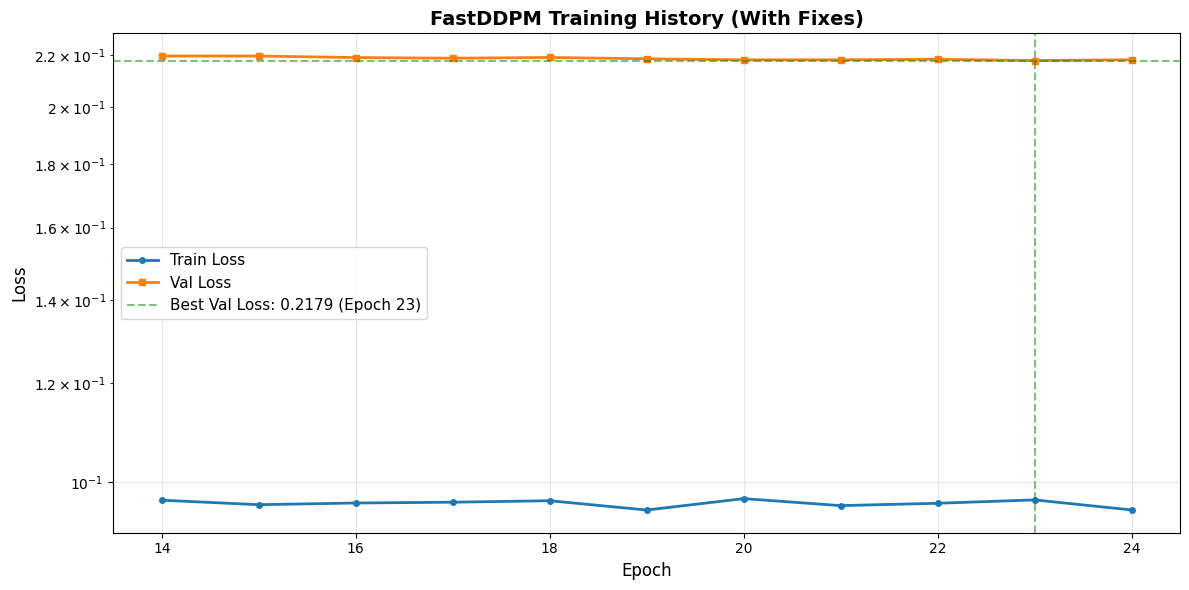

✅ Plot saved
Best validation loss: 0.2179 at epoch 23


In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history['epoch'], history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=4)
plt.plot(history['epoch'], history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=4)

best_val_loss = min(history['val_loss'])
best_epoch = history['epoch'][history['val_loss'].index(best_val_loss)]
plt.axhline(y=best_val_loss, color='g', linestyle='--', alpha=0.5, label=f'Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})')
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('FastDDPM Training History (With Fixes)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig(f'{results_dir}/fastddpm_training_lin_sch.png', dpi=150)
plt.show()

print(f"✅ Plot saved")
print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")

## 10. Evaluation on Test Set

In [11]:
# Load best model
model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/fastddpm_lin_sch_best.pt', map_location=DEVICE))

ssim_scores = []
psnr_scores = []
predictions = []
targets_list = []

print("Running evaluation on test set...")
for (pre, post), target in tqdm(test_loader, desc="Testing"):
    generated = sample(pre, post, num_samples=3)  # (B, 1, H, W)
    predictions.append(generated.cpu())
    targets_list.append(target.cpu())
    
    # FIX: Proper tensor shape handling
    pred = generated.squeeze(1).cpu().numpy()  # (B, H, W)
    gt = target.squeeze(1).cpu().numpy()       # (B, H, W)
    
    for i in range(len(gt)):
        gt_norm = (gt[i] - gt[i].min()) / (gt[i].max() - gt[i].min() + 1e-8)
        pred_norm = (pred[i] - pred[i].min()) / (pred[i].max() - pred[i].min() + 1e-8)
        
        ssim_scores.append(ssim(gt_norm, pred_norm, data_range=1.0))
        psnr_scores.append(psnr(gt_norm, pred_norm, data_range=1.0))
    
    del generated, pred, gt, gt_norm, pred_norm
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"FastDDPM Test Set Performance (with fixes)")
print(f"{'='*60}")
print(f"SSIM: {np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}")
print(f"PSNR: {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f} dB")
print(f"{'='*60}")

Running evaluation on test set...


Testing: 100%|██████████| 4560/4560 [34:34<00:00,  2.20it/s]  



FastDDPM Test Set Performance (with fixes)
SSIM: 0.5355 ± 0.0901
PSNR: 20.48 ± 3.62 dB


In [ ]:
# Load best model
model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/fastddpm_lin_sch_best.pt', map_location=DEVICE))

predictions = []
targets_list = []

print("Running evaluation on test set...")
for (pre, post), target in tqdm(test_loader, desc="Testing"):
    generated = sample(pre, post, num_samples=3)  # (B, 1, H, W)
    predictions.append(generated.cpu())
    targets_list.append(target.cpu())
    
    # FIX: Proper tensor shape handling
    pred = generated.squeeze(1).cpu().numpy()  # (B, H, W)
    gt = target.squeeze(1).cpu().numpy()       # (B, H, W)
    
    del generated, pred, gt
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()
        
    break

In [ ]:
# Concatenate all predictions and targets
all_predictions = torch.cat(predictions, dim=0)  # (N, 1, H, W)
all_targets = torch.cat(targets_list, dim=0)      # (N, 1, H, W)

# Visualize some predictions
n_samples = 4
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

# Calculate global min/max for difference colorbar across all samples
all_diffs = []
for i in range(n_samples):
    pred = all_predictions[i, 0].numpy()
    target = all_targets[i, 0].numpy()
    diff = np.abs(pred - target)
    all_diffs.append(diff)

vmin_diff = min([d.min() for d in all_diffs])
vmax_diff = max([d.max() for d in all_diffs])

for i in range(n_samples):
    pred = all_predictions[i, 0].numpy()
    target = all_targets[i, 0].numpy()
    diff = np.abs(pred - target)
    
    axes[i, 0].imshow(target, cmap='gray')
    axes[i, 0].set_title(f'Target Slice {i+1}', fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(pred, cmap='gray')
    axes[i, 1].set_title(f'Predicted Slice {i+1}', fontweight='bold')
    axes[i, 1].axis('off')
    
    im = axes[i, 2].imshow(diff, cmap='hot', vmin=vmin_diff, vmax=vmax_diff)
    axes[i, 2].set_title(f'Difference {i+1}', fontweight='bold')
    axes[i, 2].axis('off')
    plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
pred_path = results_dir + '/fast_ddpm_predictions_lin_sch.png'
plt.savefig(pred_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Predictions visualization saved to {pred_path}")